In [1]:
!pip install xgboost graphviz lightgbm scikit-learn --upgrade --quiet
!pip install openpyxl pyarrow --quiet
!pip install plotly matplotlib seaborn --quiet

In [8]:
# Importing libs
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [4]:
# Loading data
raw_df = pd.read_excel("UseCase_PipelineForecast_raw.xlsx",sheet_name="Won&Lost Opportunities YTD")
test_df = pd.read_excel("UseCase_PipelineForecast_raw.xlsx",sheet_name="Open Opportunities BOM")

# Preprocessing

In [5]:
# Separate into train and val set
#from sklearn.model_selection import train_test_split
#train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df = raw_df[raw_df.Month <=5]
val_df = raw_df[raw_df.Month >5]

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (37, 7)
val_df.shape : (26, 7)
test_df.shape : (145, 7)


In [6]:
# Declaring input features and targets
input_cols = ["Month","Region", "Customer Type", "Product"]
target_col = "Status"

train_inputs = train_df[input_cols].copy()
train_targets = train_df.Status.map(dict(Won=1,Lost=0)).copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df.Status.map(dict(Won=1,Lost=0)).copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

# Splitting between numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = ["Region", "Customer Type", "Product"]

# Feature engineering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Training and Evaluation

In [9]:
# Hyperparameter optimization using RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Hyper Parameter Optimization
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [1, 3, 5, 7, 9],
 "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
 "colsample_bytree" : [0.3, 0.4, 0.5, 0.7, 0.9]   
}

# Train model
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1)
random_search.fit(X_train, train_targets)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='roc_auc')

In [10]:
random_search.best_params_

{'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.3,
 'gamma': 0.5,
 'colsample_bytree': 0.9}

In [11]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [12]:
random_search.score(X_train, train_targets)

0.8573717948717949

In [13]:
random_search.score(X_val, val_targets)

0.65625

In [32]:
# Train model with hyperparameters
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=130, max_depth=4, 
                      learning_rate=0.3,subsample=0.4,colsample_bytree=0.9)
model.fit(X_train, train_targets)

# Predictions
train_preds=model.predict(X_train)
val_preds=model.predict(X_val)
test_preds=model.predict(X_test)

# Accuracy of training set
model.score(X_train, train_targets)

0.7837837837837838

In [33]:
# Accuracy of validation set
model.score(X_val, val_targets)

0.6153846153846154

In [34]:
# Comparing model to dummy-model
def all_no(inputs):
    return np.full(len(inputs), 0)
accuracy_score(val_targets, all_no(X_val))

0.6153846153846154

In [17]:
# Function to plot confusion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 72.97%


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

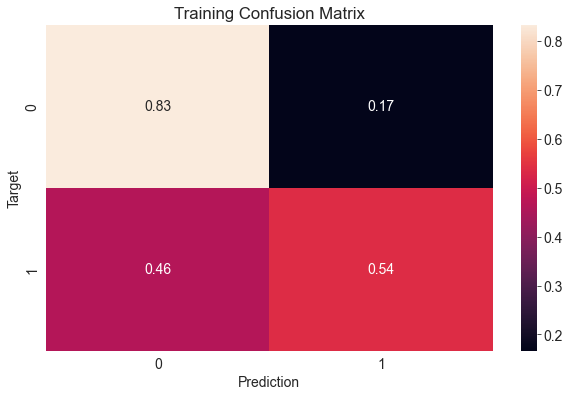

In [18]:
# Training confusion matrix
predict_and_plot(X_train, train_targets,"Training")

Accuracy: 61.54%


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1])

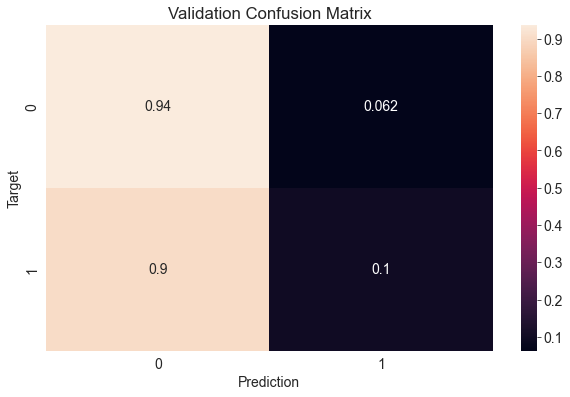

In [19]:
# Validation confusion matrix
predict_and_plot(X_val, val_targets,"Validation")

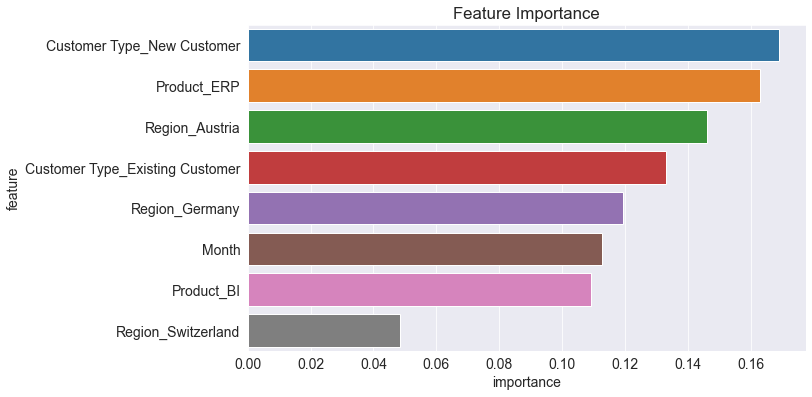

In [20]:
# Plotting feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# Other Models

In [21]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(solver='liblinear',random_state=42)
model1.fit(X_train, train_targets)
model1.score(X_train, train_targets)

0.7297297297297297

In [22]:
model1.score(X_val, val_targets)

0.6923076923076923

In [23]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100, max_depth=5, max_features=8)
model2.fit(X_train, train_targets)
model2.score(X_train, train_targets)

0.8918918918918919

In [24]:
model2.score(X_val, val_targets)

0.5384615384615384

In [25]:
from sklearn.linear_model import SGDClassifier
model3 = SGDClassifier(n_jobs=-1, random_state=42, max_iter=1000)
model3.fit(X_train, train_targets)
model3.score(X_train, train_targets)

0.5405405405405406

In [26]:
model3.score(X_val, val_targets)

0.46153846153846156

# Exporting Data

In [27]:
# Creating a df where Status is Lost/Won based on predictions of the model
test_list= test_preds.tolist()
test_list_df = pd.DataFrame({
    'Status': test_list
})
test_closed_df = test_df.copy()
test_closed_df["Status"]=test_list_df["Status"]
test_closed_df["Status"] = test_closed_df["Status"].replace([0,1],["Lost","Won"])
#test_closed_df[test_closed_df.Status == "Won"].sort_values("Month")

In [30]:
# New given inputs
new_input1={"Month":8,
          "Region_Austria":0,
          "Region_Germany":1,
          "Region_Switzerland":0,
          "Customer Type_Existing Customer":1,
          "Customer Type_New Customer":0,
          "Product_BI":0,
          "Product_ERP":1}
new_input2={"Month":8,
          "Region_Austria":0,
          "Region_Germany":0,
          "Region_Switzerland":1,
          "Customer Type_Existing Customer":0,
          "Customer Type_New Customer":1,
          "Product_BI":1,
          "Product_ERP":0}
new_input3={"Month":8,
          "Region_Austria":1,
          "Region_Germany":0,
          "Region_Switzerland":0,
          "Customer Type_Existing Customer":1,
          "Customer Type_New Customer":0,
          "Product_BI":0,
          "Product_ERP":1}

# Feature engineering new inputs
new_input_df = pd.DataFrame([new_input1, new_input2, new_input3])

new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])

# Predicting new inputs
input_preds=model.predict(new_input_df)

# Merging predictions into new input dataframe
input_list= input_preds.tolist()
input_list_df = pd.DataFrame({
    'Status': input_list
})
input_closed_df = new_input_df.copy()
input_closed_df["Status"]="Lost"
input_closed_df["Status"]=input_list_df["Status"]
input_closed_df["Status"] = input_closed_df["Status"].replace([0,1],["Lost","Won"])
input_closed_df

,Month,Region_Austria,Region_Germany,Region_Switzerland,Customer Type_Existing Customer,Customer Type_New Customer,Product_BI,Product_ERP,Status
0,0.875,0,1,0,1,0,0,1,Lost
1,0.875,0,0,1,0,1,1,0,Lost
2,0.875,1,0,0,1,0,0,1,Lost


In [31]:
# Creating an excelfile with the results of analysis
with pd.ExcelWriter('result_dfs.xlsx') as writer:  
    test_closed_df.to_excel(writer, sheet_name='test_closed')
    importance_df.to_excel(writer, sheet_name='feature_importance')
    input_closed_df.to_excel(writer, sheet_name='input_closed')